# " On arrête de jouer avec notre caca "
- Prof, 2025

In [103]:
!python -m pip install torch torchvision torchaudio matplotlib pandas graphviz

In [104]:
import torch
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [105]:
# Importer des données : un dataset préfait (MNIST)

training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [106]:
print(training_dataset)
print(training_dataset.data.shape)
print(training_dataset.targets.shape)
print(training_dataset.targets.unique())
print(training_dataset.targets.bincount())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


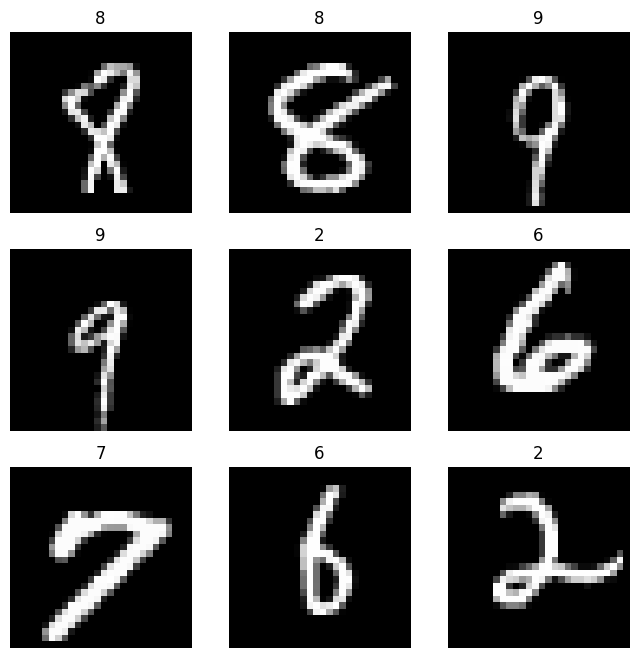

In [107]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [108]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(training_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f'shape X : {X.shape}')
    print(f'shape y : {y.shape}')
    break

shape X : torch.Size([64, 1, 28, 28])
shape y : torch.Size([64])


In [109]:
train_features, train_labels = next(iter(train_dataloader))
train_features.shape

torch.Size([64, 1, 28, 28])

In [110]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, dims):
        super(MLP, self).__init__()
        self.fcs = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(len(dims) - 1)]
        )
        self.act = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x): # fait : 1 * 28 * 28 --> 1 * 784
        x = self.flatten(x)
        for layer in self.fcs:
            x = layer(x)
            x = self.act(x)
        return x

In [111]:
input_dim = 28*28
output_dim = 10

model = MLP([input_dim, 64, 64, output_dim])
model

MLP(
  (fcs): ModuleList(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [112]:
loss_fn = nn.CrossEntropyLoss() # Expect raw logits
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [113]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Prédiction
        ypred = model(X)
        loss = loss_fn(ypred, y)

        # Backpropag
        loss.backward()
        optimizer.step() # W = W - lr * grad
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size * len(X)
            print(f'loss {loss:>7f} [{current:>5d}/{len(dataloader.dataset)}]')

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            ypred = model(X)
            test_loss += loss_fn(ypred, y).item()
            correct += (ypred.argmax(1) == y).type(torch.float).sum().item()

    test_loss/=len(dataloader)
    correct/= len(dataloader.dataset)
    print(f'Test loss : {test_loss:>8f} | test accuracy {(correct * 100):7f}')
    


In [114]:
epochs = 10
for t in range(epochs):
    print(f'Epoch {t+1} ----------------------------------')
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

print("Done !")


Epoch 1 ----------------------------------
loss 2.312515 [    0/60000]
loss 1.155215 [409600/60000]
loss 0.799874 [819200/60000]
loss 1.121224 [1228800/60000]
loss 0.694312 [1638400/60000]
loss 0.753214 [2048000/60000]
loss 0.542040 [2457600/60000]
loss 1.334459 [2867200/60000]
loss 0.765149 [3276800/60000]
loss 0.997707 [3686400/60000]
Test loss : 0.857809 | test accuracy 66.090000
Epoch 2 ----------------------------------
loss 0.884832 [    0/60000]
loss 0.774101 [409600/60000]
loss 0.856421 [819200/60000]
loss 0.679492 [1228800/60000]
loss 0.765846 [1638400/60000]
loss 0.853865 [2048000/60000]
loss 0.910034 [2457600/60000]
loss 0.631789 [2867200/60000]
loss 0.737514 [3276800/60000]
loss 0.861901 [3686400/60000]
Test loss : 0.826085 | test accuracy 66.740000
Epoch 3 ----------------------------------
loss 0.463821 [    0/60000]
loss 0.786426 [409600/60000]
loss 0.687977 [819200/60000]
loss 0.832266 [1228800/60000]
loss 0.726807 [1638400/60000]
loss 0.830062 [2048000/60000]
loss 0.86